In [ ]:
%load_ext watermark

In [46]:
import pymc as pm
import pandas as pd
import altair as alt
import datetime

import arviz as az
import numpy as np
import pytensor as pt
import sqlite3 as sq
from matplotlib import pyplot as plt


import sys
sys.path.append("../")
import warnings
warnings.filterwarnings("ignore", message=".*Pareto distribution.*")
warnings.filterwarnings("ignore", message=".*external NUTS.*")


DB_PATH_2023 = './data.sqlite_2023.db'

traces = {}
models = {}

It was a bit more than a year ago that I built my first real Bayesian model. As part of Georgia Tech's Bayesian Statistics class, I attempted to quantify home court advantage in Lithuanian Basketball League. I got that it is ~2.3-2.6 points, somewhat below what has been found in NBA. Since then, I learned quite a bit more about Bayesian modelling, and I thought I'll revisit the problem. In case you're interesting in the previous work or want to grab code that scrapes all the data I am using in this post, I suggest to check out a [dedicated repo](https://github.com/kamicollo/home-court-advantage) I have for that project.

As usual, my blog posts include all the code - but if you want to follow through a full notebook with everything, you can find it @ https://github.com/kamicollo/blog-posts.

Previously, I approached the problem by modelling the outcome of the game as a function of pair-wise team strength differences, plus the home court advantage of one of the teams. The simplest variation of the models I explored was:

$$
O^{s,k}_{i,j} \sim \text{Normal}(\alpha^{s}_{i,j} + β_i H^{k}_i - β_j H^{k}_j, \epsilon) \\
\alpha^{s}_{i,j} \sim \text{Normal}(0, 10) \\
\beta_{t} \sim \text{Normal}(4, 10) \\
\epsilon^{s} \sim \text{HalfCauchy}(5) \\
\\
$$

where $O^{k}_{i,j}$ is the score differential of game $k$ in season $s$ between teams $i$ and $j$, $\alpha^{s}_{i,j}$ is the pair-wise strength differential between teams $i$ and $j$ in season $s$, and $H^{k}_t$ is an indicator variable whether the team $t$ is playing at home. The main parameters of interest are $\beta_{t}$.

Looking back at the modelling approach, a couple of things immediatelly caught my eye:

* It's interesting I chose to model pair-wise strengths instead of latent team strengths themselves. I wrote some justification for it in the accompanying report, but reading it today it doesn't make so much sense. Especially given that I modelled them indepedently. Surely they should be correlated!
 * The prior for $\beta$ is way too flat. It implies that the home court advantage is likely to take values as extreme as -15 to +20 points. I chose mean of $4$ based on prior research, but the combination with such a high variance wasn't the smartest choice🤦‍♂️. 
 * I fit the above model on one season of data and also on multiple seasons, where I represented each team/season combination as a separate entity. I chose that because team strengths don't stay constant throughout seasons - but looking back, treating them as completely independent was't the best approach either.

In any way - let's fit this model one more time (but with better priors) so that it's available as a baseline. I'll be using data across all seasons since 1995, excluding KMT cup games (the scraper I wrote last year still worked, so I downloaded a bit more data, too). Here's how it looks like.

In [47]:
with sq.connect(DB_PATH_2023) as conn:
    sql = """
    SELECT `home-points`, `away-points`, `home-points` - `away-points` as `score_diff`,
    ht.name as `home-team`, at.name as `away-team`, 
    `start-year` as season, `date`
    FROM games
    JOIN seasons ON games.season_id = seasons.id
    JOIN teams ht ON `home-team-id` = ht.id
    JOIN teams at ON `away-team-id` = at.id
    WHERE `regular` = 1 AND `start-year` > '1994'
    ORDER BY `game-id`
    ;
    """
    all_games = pd.read_sql_query(sql, conn)

def helper_(x):
    return (max(x['home-team'], x['away-team']), min(x['home-team'], x['away-team']))
all_games['pair'] = all_games.apply(helper_, axis=1)
all_games['pair_is_reversed'] = all_games.apply(
    lambda x: 1 if x['pair'][0] == x['home-team'] else -1, 
    axis=1
)
all_games['pair_string'] = all_games['pair'].apply(lambda x: x[0] + "-" + x[1])
teams_from_2022 = all_games['home-team'][all_games['season'] == '2022'].unique()
pairs_2022 = all_games['pair_string'][all_games['season'] == '2022'].unique()
all_games[['home-team', 'away-team', 'season', 'home-points', 'away-points', 'date', 'score_diff']].head()

,home-team,away-team,season,home-points,away-points,date,score_diff
0,7bet-Lietkabelis,Uniclub Casino - Juventus,2017,92,85,2017-09-19 00:00:00,7
1,Šiauliai,Uniclub Casino - Juventus,2017,82,73,2017-09-26 00:00:00,9
2,Rytas,Wolves,2017,105,84,2018-01-27 00:00:00,21
3,Neptūnas,7bet-Lietkabelis,2017,83,78,2018-01-27 00:00:00,5
4,Pieno žvaigždės,Rytas,2021,66,76,2021-09-18 00:00:00,-10


In [48]:
#SHOW

#get variables for modelling
score_diffs = (all_games['score_diff']).values
strengths_reversed = (all_games['pair_is_reversed']).values
pairs_idx, pairs = pd.factorize(all_games['pair_string'], sort=True)
season_idx, seasons = pd.factorize(all_games['season'], sort=True)
home_team_idx, hteams = pd.factorize(all_games['home-team'], sort=True)
away_team_idx, ateams = pd.factorize(all_games['away-team'], sort=True)

#make sure away and home teams are the same
assert(set(ateams) == set(hteams))

In [49]:
#SHOW
with pm.Model(
    coords = {
        'pairs': pairs,
        'teams': ateams,
        'seasons': seasons
    }
) as baseline_model:
    α = pm.Normal('Pair-strengths', 0, 10, dims=('seasons', 'pairs'))
    β = pm.Normal('HC-adv', 4, 2, dims=('teams'))
    ε = pm.HalfCauchy('error', 5, dims='seasons')

    S = α[season_idx, pairs_idx] * strengths_reversed + β[home_team_idx]
    
    pm.Normal('scores', mu=S, sigma=ε[season_idx], observed=score_diffs)

models['Baseline'] = baseline_model


In [50]:
def fit_models(models, traces, refit=False):
    for name, model in models.items():
        if (name not in traces) or refit:
            import sys
            stdout = sys.stdout
            sys.stdout = None
            try:
                traces[name] = pm.sample(
                    nuts_sampler="blackjax",         
                    random_seed=np.random.default_rng(1),
                    idata_kwargs={'log_likelihood': True},
                    model = model
                )
            finally:
                sys.stdout = stdout

In [51]:
fit_models(models, traces)

Let's see if the model converged based on max $\hat{R}s$ across the parameter space. Let's also visualize the home court advantage estimates (limited to teams that still exist as of 2022-2023 season).

In [52]:
def show_diagnostics(traces):
    records = []
    for name, trace in traces.items():        
        r = az.rhat(trace)
        d = {'Model': name}
        d.update(r.to_dataframe().max().to_dict())        
        records.append(d)    
    display(pd.DataFrame(records).round(2))

In [53]:
show_diagnostics(traces)

,Model,Pair-strengths,HC-adv,error
0,Baseline,1.01,1.0,1.0


In [54]:
def plot_hc_adv(traces):
    dfs = []
    for n,t in traces.items():
        hdis = az.hdi(
            t['posterior']['HC-adv'].sel(teams=teams_from_2022)
        ).to_dataframe().reset_index().pivot(
            columns='hdi', index='teams', values='HC-adv'
        )

        means = t['posterior']['HC-adv'].sel(teams=teams_from_2022).mean(dim=('chain','draw')).to_dataframe()
        df = hdis.join(means)
        df['model'] = n
        dfs.append(df.reset_index())
    
    chart = alt.Chart(pd.concat(dfs)).encode(alt.X('model', title='', axis=alt.Axis(labels=False)), alt.Color('model'))

    points = chart.mark_point().encode(
        alt.Y('HC-adv', title='Home court advantage'), 
    )
    lines = chart.mark_errorbar().encode(
        alt.Y('lower', title=""), alt.Y2('higher', title=''), 
    )

    return (points + lines).properties(height=150, width=80).facet(facet='teams', columns=4, spacing=10).interactive()

In [55]:
plot_hc_adv(traces)

alt.FacetChart(...)

Everything looks good from convergence perspective, but the home court advantage estimates vary a lot among teams. If you are familiar with Lithuanian basketball, you will also notice that they correlate with the strength of the teams (Žalgiris and Rytas are the two teams that have been battling for the champion title pretty much every season with a few exceptions). I suspect this model specification leads to some "spillover" effect from the team strength itself into the home court advantage estimates - although it could be that those teams have strongest fan support, too. What would other approaches yield?

## Latent team strengths

I'll start with something simple:

 * Instead of modelling pairwise strengths (where only a few observations are available each season), I'll simply model latent team strengths, and assume that the score differential is a function of team's strengths' differences.
 * I'll introduce a hierarchical structure to the home court advantages. I think the model may benefit from partial pooling, especially given the wide range of estimates seen in the previous specification.

The model could be written as (in practice, I use a non-centered parameterization for the hierarchical effects):
$$
O^{s,k}_{i,j} \sim \text{Normal}(\alpha^{s}_{i} - \alpha^{s}_{j} + β_i H^{k}_i - β_j H^{k}_j, \epsilon) \\
\alpha^{s}_{i} \sim \text{Normal}(0, 5) \\
\bar{\beta} \sim \text{Normal}(4, 2) \\
γ \sim \text{HalfNormal}(2) \\
\beta_{t} \sim \text{Normal}(\bar{\beta}, γ) \\
\epsilon^{s} \sim \text{HalfCauchy}(5) \\
$$

In [56]:
#SHOW

with pm.Model(
    coords = {
        'pairs': pairs,
        'teams': ateams,
        'seasons': seasons
    }
) as latent_strengths:
    #team strengths
    α = pm.Normal('Team-strength', 0, 5, dims=('seasons', 'teams'))

    #home court advantages
    β_h = pm.Normal("HC", 4, 2)
    Z_b = pm.Normal("offsets", 0, 1, dims=("teams"))
    σ_b = pm.HalfNormal("σ", 2)
    β = pm.Deterministic("HC-adv", β_h + Z_b*σ_b, dims=('teams'))    

    #error term
    ε = pm.HalfCauchy('error', 5, dims='seasons')

    #likelihood
    S = α[season_idx, home_team_idx] - α[season_idx, away_team_idx] + β[home_team_idx]
    pm.Normal('scores', mu=S, sigma=ε[season_idx], observed=score_diffs)

models['Latent team strengths'] = latent_strengths

In [57]:
fit_models(models, traces)   

In [58]:
show_diagnostics(traces)
plot_hc_adv(traces)

,Model,Pair-strengths,HC-adv,error,Team-strength,HC,offsets,σ
0,Baseline,1.01,1.0,1.0,NaN,NaN,NaN,NaN
1,Latent team strengths,NaN,1.0,1.0,1.01,1.0,1.0,1.0


alt.FacetChart(...)

This model also converges nicely. Looking at home court advantage estimates, we observe some regularization taking place, but it still attributes the largest effects to the strongest teams. Perhaps that's indeed true - they have the largest arenas, after all.

Let's compare it to the previous model using leave-one-out cross validation. Turns out, it's actually better.

In [59]:
def compare_models(traces):
    az.plot_compare(
        az.compare(traces),
        figsize=(7,4),
        textsize=7
    )
    plt.show()

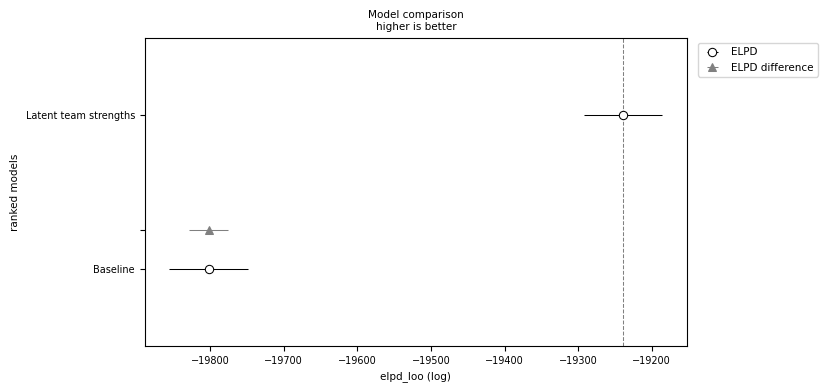

In [60]:
compare_models(traces)

We also get team strengths - which is an interesting variable on its own. Let's visualize them over time. Anyone familiar with Lithuanian basketball will recognize some real trends here. Because of how the model is specified, we also get estimates of team strengths in seasons they did not exist - that's why some of the credible intervals are so wide.

In [61]:
def plot_strengths(traces):
    dfs = []
    for name, trace in traces.items():
        if 'Team-strength' in trace['posterior']:
            strengths = trace['posterior']['Team-strength'].sel(
                teams=teams_from_2022
            )

            df = az.hdi(strengths).to_dataframe().reset_index().pivot(
                index=['seasons', 'teams'], columns='hdi', values='Team-strength'
            ).join(
            strengths.mean(dim=('chain','draw')).round(2).to_dataframe()
            ).reset_index()

            df['date'] = pd.to_datetime(
                df['seasons'].astype('int').apply(lambda x: datetime.date(x,1,1))
            )
            df['model'] = name
            dfs.append(df)
    all_df = pd.concat(dfs)

    c = alt.Chart(all_df).encode(
        alt.X('date'), alt.Color('model'),
        alt.Tooltip(['teams', 'seasons', 'Team-strength']),
    )
    
    lines = c.mark_line().encode(alt.Y('Team-strength'))

    area = c.mark_area(opacity=0.7).encode(alt.Y('lower', title=""), alt.Y2("higher", title=""))
    
    return (lines + area).interactive().properties(height=100, width=80).facet('teams', columns=4)

In [62]:
plot_strengths(traces)

alt.FacetChart(...)

Let's specifically compare the strengths of two archrivals - Kauno Žalgiris and Vilniaus Rytas. This model isn't very certain on who is stronger this year! Žalgiris is stronger, but the model is gives around 50% that the differential is less that ~3 points.

In [63]:
def plot_zalgiris_rytas(traces):
    dfs = []
    for n,t in traces.items():
        if 'Team-strength' in t['posterior']:
            zalgiris = t['posterior']['Team-strength'].sel(
                teams=['Žalgiris']
            ).squeeze()

            rytas = t['posterior']['Team-strength'].sel(
                teams=['Rytas']
            ).squeeze()

            diff = (zalgiris - rytas).rename('diff')

            hdis = az.hdi(
                diff
            ).to_dataframe().reset_index().pivot(
                columns='hdi', index='seasons', values='diff'
            )

            means = diff.mean(dim=('chain','draw')).to_dataframe()
            df = hdis.join(means)
            df['model'] = n
            dfs.append(df.reset_index())
    
    chart = alt.Chart(pd.concat(dfs)).encode(alt.X('seasons',), alt.Color('model'))

    points = chart.mark_line().encode(
        alt.Y('diff', title='Strength difference'), 
    )
    lines = chart.mark_area(opacity=0.5).encode(
        alt.Y('lower', title=""), alt.Y2('higher', title=''), 
    )

    return (points + lines).properties(height=200, width=400).interactive()

In [64]:
plot_zalgiris_rytas(traces).properties(title='Žalgiris vs. Rytas strength differences')

alt.LayerChart(...)

## Improving the model with Gaussian Processes

Could we make this model even better? One obvious area of improvement is the fact that so far the model treats all seasons as independent observations. What if, instead, team's strength was modelled as a function of season, but allowing for correlation between seasons? That's a good use case for Gaussian Processes.

The full model specification is thus as follows:

$$
O^{s,k}_{i,j} \sim \text{Normal}(\alpha^{s}_{i} - \alpha^{s}_{j} + β_i H^{k}_i - β_j H^{k}_j, \epsilon) \\
\alpha^{s}_{t} \sim \text{GP}_t(0, f(s, l_t, \eta_t^{2})) \\
l_t \sim \frac{1}{2}Exp(1) \\
\eta_t^{2} \sim Exp(1) \\
\bar{\beta} \sim \text{Normal}(4, 2) \\
γ \sim \text{HalfNormal}(2) \\
\beta_{t} \sim \text{Normal}(\bar{\beta}, γ) \\
\epsilon^{s} \sim \text{HalfCauchy}(5) \\
$$

The one complication with this specification is that it means fitting one Gaussian Process per team. A naive for loop to specify them is not the way we want to go (I tried - compilation of the model alone took 18 minutes). An alternative would be to have just one GP, where teams are encoded in a one-of-k fashion. That would result in a (seasons x teams) x (teams + 1) dataset, though (the chosen specification is effectively seasons x teams). I tried that specification, too, but after running the sampling for over an hour, I gave up. The specifications used in this blog post, on the other hand, take just a few minutes to sample.

It should be possible to define such a model using pyMC's GP module and leveraging `pytensor.scan` which is a "loop-like" functionality for such situations. But I could not get past some initial errors, and I did not want to `scan` everything - I wanted to see if I could solve at least some of the steps via broadcasting. Plus, it was educational in getting to understand pyMC's GP internals.

It took a while and I had some really strong flashbacks of linaear algebra monsters from my Master's, but I made it work!

First, we need an Exponential kernel that can handle 3D data:

In [65]:
#SHOW 

class ExpQuad3D(pm.gp.cov.Stationary):
    def __init__(self, ls=None, ls_inv=None, active_dims=None, eta=1, pymc_compat=False):
        super().__init__(input_dim=1, active_dims=active_dims, ls=ls, ls_inv=ls_inv)                
        self.eta = pt.tensor.as_tensor_variable(eta)        
        self.pymc_compat = pymc_compat

    def square_dist(self, X, Xs):        
        if Xs is None:
            s = pt.tensor.square(X).sum(axis=-1)
            sqd = -2 * pt.tensor.matmul(
                X, X.transpose(0, 2, 1)
            ) + pt.tensor.expand_dims(s, -2) + pt.tensor.expand_dims(s, -1)
        else:
            raise NotImplementedError
        return pt.tensor.clip(sqd, 0.0, np.inf)
        
    def full(self, X, Xs=None):        
        cov_kernels = self.cov_kernel(X, Xs)
        return cov_kernels
        
    def quad_kernel(self, X, Xs, ls):
        if self.pymc_compat:
            return pt.tensor.exp(-0.5 * self.square_dist(X / ls, Xs))
        else:
            return pt.tensor.exp(-0.5 * self.square_dist(X, Xs) / ls)
        
    def cov_kernel(self, X, Xs):
        K = self.quad_kernel(X, Xs, self.ls)
        result, _ = pt.scan(
            fn=lambda A: A + (1e-6 * pt.tensor.identity_like(A)),     
            sequences=K
        )
        
        return pt.tensor.mul(
            result,
            self.eta
        )


Just to make sure it works correctly, we can compare results of it vs. the built-in pyMC class. Note that in the actual model fitting, I use a slightly different parameterization (controlled via `pymc_compat` parameter). For context on how they are different, see a forum post on [pyMC Discourse](https://discourse.pymc.io/t/gaussian-process-lengthscale-parameterization-trigger-of-compound-sampler/12225).

In [66]:
#SHOW 

#3D array of season variables (which are 0-indexed)
season_indicators = np.tile(np.sort(np.unique(season_idx)).reshape(-1, 1), (len(ateams), 1, 1))

#a different lengthscale for each team
lses = np.expand_dims(np.arange(len(ateams)) + 0.1, 0).reshape(-1, 1, 1)

#comparing outputs
result_3d = ExpQuad3D(ls=lses, pymc_compat=True).full(pt.tensor.as_tensor_variable(season_indicators)).eval()
results_pymc = np.array([pm.gp.cov.ExpQuad(input_dim=1, ls=ls).full(s).eval() for ls, s in zip(lses, season_indicators)])
np.allclose(result_3d, results_pymc)


True

And now we can use that in a pyMC model, replicating most of what the GP model does under the hood:

In [67]:
#SHOW 

with pm.Model(
    coords = {
        'pairs': pairs,
        'teams': ateams,
        'seasons': seasons
    }
) as team_level_gps:
    
    #home court advantage
    β_h = pm.Normal("HC", 4, 2)
    Z_b = pm.Normal("offsets", 0, 1, dims=("teams"))
    σ_b = pm.HalfCauchy("σ", 2)
    β = pm.Deterministic("HC-adv", β_h + Z_b*σ_b, dims=('teams'))

    #error term
    ε = pm.HalfCauchy('error', 5, dims='seasons')

    # GP priors
    ls = (2 * pm.Exponential("ls_team", 1.0, dims="teams"))[:, None, None] 
    η = pm.Exponential("η_squared", 1.0, dims='teams')[:, None, None]     

    #getting the covariances
    cov_func = ExpQuad3D(ls=ls, eta=η)
    covariances = cov_func.full(X=pt.tensor.as_tensor_variable(season_indicators), Xs=None)

    chols, _ = pt.scan(
        fn=lambda C: pm.gp.util.cholesky(C),     
        sequences=covariances
    )

    #GP for the team strength
    Zs = pm.Normal("GP_offsets", mu=0, sigma=1, dims=('teams', 'seasons'))
    α = pm.Deterministic(
        "Team-strength", 
        pt.tensor.batched_dot(chols, Zs), 
        dims=('teams', 'seasons')
    )

    S = α[home_team_idx, season_idx] - α[away_team_idx, season_idx] + β[home_team_idx]
    
    pm.Normal('scores', mu=S, sigma=ε[season_idx], observed=score_diffs)

models['Gaussian Process'] = team_level_gps

In [68]:
fit_models(models, traces)

This model also samples pretty well.

In [69]:
show_diagnostics(traces)

,Model,Pair-strengths,HC-adv,error,Team-strength,HC,offsets,σ,GP_offsets,ls_team,η_squared
0,Baseline,1.01,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Latent team strengths,NaN,1.0,1.0,1.01,1.0,1.0,1.0,NaN,NaN,NaN
2,Gaussian Process,NaN,1.0,1.0,1.01,1.0,1.0,1.0,1.01,1.01,1.0


Let's see what latent team strengths we got this time. For comparison, I'll overlay the strengths learned by the previous model, too.

In [70]:
plot_strengths(traces)

alt.FacetChart(...)

I don't know about you, but I find it really cool how GP's work. With just 2 parameters per team ($ls$ and $\eta$), the model learned these sort of intricate shapes. I also find it fascinating what it learned. When it comes to teams that are constant title contenders (Žalgiris and Rytas), the functions learned are very smooth. The same applies to other teams that are often battling for 3-4th position - e.g. Neptūnas and Šiauliai. At the same time, it's not that GP's simply smoothened out what the previous model learned via independent parameters. For some teams - e.g. Lietkabelis or Labas Gas, the team strengths learned are nearly as wiggly as the ones learned previously.

What about home court advantages themselves? They are quite different, too. The strongest teams no longer have such dominant advantages; in fact, excluding Wolves (which is a new team established just this season), the highest mean homecourt advantage now belongs to Šiauliai.

In [71]:
plot_hc_adv(traces)

alt.FacetChart(...)

Is this model actually better, from cross-validation perspective? It's just a bit worse than the previous model, it turns out.

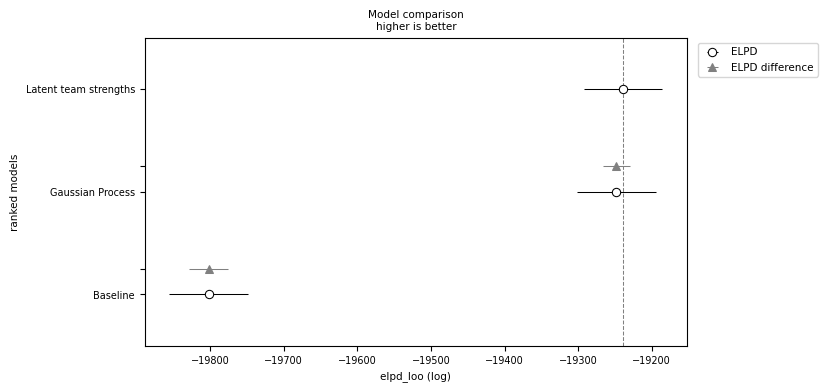

In [72]:
compare_models(traces)

## Gaussian Process with a latent team baseline strength

Could we make better? Let's do one modification to the GP model. So far, the GP's were zero-mean, i.e. the entire team strength function was fully dependent on the season. Let's change that by modelling a latent "baseline" team strength which would be constant over time, while the GP will then capture variations around that baseline. 

You could argue whether this assumption is a really good one - to me, it represents the fact that some teams are more established than others. It is also an opportunity to provide some informative priors to the model. Specifically, I set the priors as 10 for Žalgiris, 8 for Rytas, 5 for Lietkabelis, Šiauliai, Neptūnas and Juventus, while all the other teams' strength is set to 0.

In [73]:
team_strength_priors = {
    '7bet-Lietkabelis':5, 
        'Neptūnas':5, 
         'Rytas':8,
       'Uniclub Casino - Juventus':5,
       'Šiauliai': 5, 'Žalgiris':10}

all_priors = [team_strength_priors[t] if t in team_strength_priors else 0 for t in ateams]

In [74]:
#SHOW 

with pm.Model(
    coords = {
        'pairs': pairs,
        'teams': ateams,
        'seasons': seasons
    }
) as team_level_gps_with_strength:
    
    #home court advantage
    β_h = pm.Normal("HC", 4, 2)
    Z_b = pm.Normal("offsets", 0, 1, dims=("teams"))
    σ_b = pm.HalfCauchy("σ", 2)
    β = pm.Deterministic("HC-adv", β_h + Z_b*σ_b, dims=('teams'))

    #error term
    ε = pm.HalfCauchy('error', 5, dims='seasons')

    # GP priors
    ls = 1 / (2 * pm.Exponential("ls_team", 1.0, dims="teams"))[:, None, None] 
    η = pm.Exponential("η_squared", 1.0, dims='teams')[:, None, None] 

    #getting the covariances
    cov_func = ExpQuad3D(ls=ls, eta=η)
    covariances = cov_func.full(X=pt.tensor.as_tensor_variable(season_indicators), Xs=None)

    chols, _ = pt.scan(
        fn=lambda C: pm.gp.util.cholesky(C),     
        sequences=covariances
    )

    #GP for the team strength
    baseline_a = pt.tensor.expand_dims(pm.Normal('baseline_str', all_priors, 5, dims=('teams')), 1)
    Zs = pm.Normal("GP_offsets", mu=0, sigma=1, dims=('teams', 'seasons'))
    α = pm.Deterministic(
        "Team-strength", 
        pt.tensor.batched_dot(chols, Zs) + baseline_a,
        dims=('teams', 'seasons')
    )    

    S = α[home_team_idx, season_idx] - α[away_team_idx, season_idx] + β[home_team_idx]
    
    pm.Normal('scores', mu=S, sigma=ε[season_idx], observed=score_diffs)

models['GP with baseline strength'] = team_level_gps_with_strength

In [75]:
fit_models(models, traces)

In [76]:
show_diagnostics(traces)

,Model,Pair-strengths,HC-adv,error,Team-strength,HC,offsets,σ,GP_offsets,ls_team,η_squared,baseline_str
0,Baseline,1.01,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Latent team strengths,NaN,1.0,1.0,1.01,1.0,1.0,1.0,NaN,NaN,NaN,NaN
2,Gaussian Process,NaN,1.0,1.0,1.01,1.0,1.0,1.0,1.01,1.01,1.0,NaN
3,GP with baseline strength,NaN,1.0,1.0,1.01,1.0,1.0,1.0,1.01,1.01,1.0,1.0


Based on ELPD, this model specification is the best so far! 

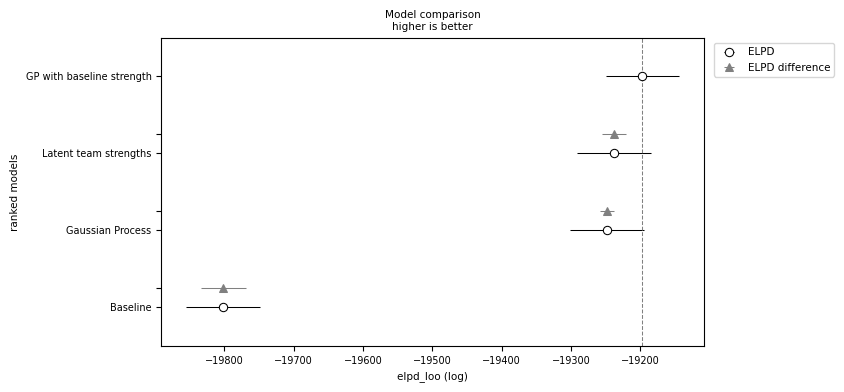

In [77]:
compare_models(traces=traces)

And this is how team strengths look like over time (note that because of how the specification is constructed, the baseline team strength gets propagated backwarrds to seasons where the team did not exist). 

In [78]:
plot_strengths({n: t for n,t in traces.items() if n != 'Latent team strengths'})

alt.FacetChart(...)

What about home court advantages? In this specification, most of the teams have very similar levels. It got me concerned for a moment that the model was simply passing through the prior information and not learning anything, but the results below are robust to home court advantage prior - setting it it $\text{Normal}(0,2)$ leads to nearly identical results.

In [79]:
plot_hc_adv(traces)

alt.FacetChart(...)

Here's a different visualization - if we were trust the final model, Šiauliai commands the largest home court advantage, at nearly 4 points, followed by Rytas, Wolves and Lietkabelis, while the overall home court advantage across the league is somewhere between 3 and 4 points.

In [80]:
def plot_hc(t):
    hdis = az.hdi(
        t['posterior']['HC-adv'].sel(teams=teams_from_2022)
    ).to_dataframe().reset_index().pivot(
        columns='hdi', index='teams', values='HC-adv'
    )

    means = t['posterior']['HC-adv'].sel(teams=teams_from_2022).mean(dim=('chain','draw')).to_dataframe()
    df = hdis.join(means).reset_index()

    latent = az.summary(t, var_names='HC', kind='stats').rename(
        {'mean': 'HC-adv', 'hdi_3%': 'lower', 'hdi_97%': 'higher'}, axis=1
    ).reset_index()
    latent['teams'] = 'Overall league'
    latent['color'] = 'league'
    df['color'] = 'team'

    df = pd.concat([df, latent])
    
    chart = alt.Chart(df).encode(alt.Y('teams', title='Team', sort=alt.EncodingSortField(field="HC-adv", op="max")), alt.Color('color'))

    points = chart.mark_point().encode(
        alt.X('HC-adv', title='Home court advantage'), 
    )
    lines = chart.mark_errorbar().encode(
        alt.X('lower', title=""), alt.X2('higher', title=''), 
    )

    return (points + lines).properties(width=400, height=250, title='Home court advantage estimates').interactive()

In [81]:
plot_hc(traces['GP with baseline strength'])

alt.LayerChart(...)

Finally, what do all the models think about Žalgiris vs. Rytas in this season? Well, zero falls into the 94% credible interval no matter which model you look at. Better grab that popcorn!

In [82]:
plot_zalgiris_rytas(traces).properties(width=400, height=100).facet(row=alt.Row('model'))

alt.FacetChart(...)

## Addendum - strength variations within a season

Originally I collected this data by season. But as I kept on working through different model specifications, I realized it would be even more fun to model team strength variations over time. Players get injured, teams develop better understanding of each other - those are just a few factors that affect team strength within the season. Could we use Gaussian Processes to model that, too?

That's the last model I tried fitting:

 * Reduced only to data from 2019 and onwards (otherwise it takes a bit too long!)
 * Each team no longer gets a baseline team strength, but instead - a baseline season strength (drawn from Normal, I didn't want to go GP-in-GP route :D)
 * Gaussian Process is fit for each team to capture variations across months

In [83]:
#SHOW 

subset_games = all_games.query('season > "2018"').copy()
subset_games['month'] = pd.to_datetime(subset_games['date']).truncate().dt.to_period('M')
subset_games['month_int'] = (subset_games['month'] - subset_games['month'].min()).apply(lambda x: x.n)


#get variables for modelling
score_diffs = (subset_games['score_diff']).values
strengths_reversed = (subset_games['pair_is_reversed']).values
pairs_idx, pairs = pd.factorize(subset_games['pair_string'], sort=True)
season_idx, seasons = pd.factorize(subset_games['season'], sort=True)
month_idx, months = pd.factorize(subset_games['month'], sort=True)
month_ints = subset_games['month_int'].sort_values()
home_team_idx, hteams = pd.factorize(subset_games['home-team'], sort=True)
away_team_idx, ateams = pd.factorize(subset_games['away-team'], sort=True)

#make sure away and home teams are the same
assert(set(ateams) == set(hteams))

#season indicators
season_indicators = np.tile(np.sort(np.unique(season_idx)).reshape(-1, 1), (len(ateams), 1, 1))
month_indicators = np.tile(np.sort(np.unique(month_ints)).reshape(-1, 1), (len(ateams), 1, 1))

In [84]:
#SHOW 

#will need this to get around vectorization producing non-existing season/month combinations
month_season_combinations = list(subset_games.apply(lambda x: (x['season'], str(x['month'])), axis=1).unique())

In [85]:
#SHOW 

with pm.Model(
    coords = {        
        'teams': ateams,
        'seasons': seasons,
        'months': months,
    }
) as in_season_variations:
    
    #home court advantage
    β_h = pm.Normal("HC", 4, 2)
    Z_b = pm.Normal("offsets", 0, 1, dims=("teams"))
    σ_b = pm.HalfCauchy("σ", 2)
    β = pm.Deterministic("HC-adv", β_h + Z_b*σ_b, dims=('teams'))

    #error term
    ε = pm.HalfCauchy('error', 5, dims='seasons')

    # GP priors
    ls = 1 / (2 * pm.Exponential("ls_team", 1.0, dims="teams"))[:, None, None] 
    η = pm.Exponential("η_squared", 1.0, dims='teams')[:, None, None] 

    #getting the covariances
    cov_func = ExpQuad3D(ls=ls, eta=η)
    covariances = cov_func.full(X=pt.tensor.as_tensor_variable(month_indicators), Xs=None)

    chols, _ = pt.scan(
        fn=lambda C: pm.gp.util.cholesky(C),     
        sequences=covariances
    )

    #GP for the team strength
    γ = pm.Normal('baseline_str', 0, 5, dims=('seasons', 'teams'))
    Zs = pm.Normal("GP_offsets", mu=0, sigma=1, dims=('teams', 'months'))
    
    monthly_strengths = pt.tensor.batched_dot(chols, Zs)
    pm.Deterministic('monthly_strengths', monthly_strengths, dims=('teams', 'months'))

    α = pm.Deterministic(
        "Team-strength", 
        pt.tensor.tile(monthly_strengths, (len(seasons),1,1)) + pt.tensor.expand_dims(γ,2),
        dims=('seasons', 'teams', 'months')
    )    

    S = α[season_idx, home_team_idx, month_idx] - α[season_idx, away_team_idx, month_idx] + β[home_team_idx]
    
    pm.Normal('scores', mu=S, sigma=ε[season_idx], observed=score_diffs)

models['GP with in-season variation'] = in_season_variations

In [86]:
fit_models(models, traces)

Here's how the team strengths look like (this time, without credible intervals):

In [87]:
r = traces['GP with in-season variation']['posterior']['Team-strength'].sel(
    teams=teams_from_2022
).mean(dim=('chain', 'draw')).to_dataframe().reset_index()

r['months'] = r['months'].astype(str)
relevant_r = r[r.apply(lambda x: (x['seasons'], x['months']) in month_season_combinations, axis=1)].copy()
relevant_r.loc[:, 'date'] = pd.to_datetime(relevant_r['months'], format="%Y-%m")

In [88]:
alt.Chart(
    relevant_r
).mark_line().encode(
    alt.X('date'), alt.Y('Team-strength'), alt.Facet('teams', columns=4), 
    alt.Tooltip(['teams', 'Team-strength']), alt.Color('seasons')
).properties(width=100, height=100).interactive()

alt.Chart(...)

But is this model any good? Unfortunately - does not seem so. To understand if the model learned any true in-season variations, it's useful to look at the lengthscale parameters. They are pretty much equal to priors - so the model did not really learn much in that regard. Perhaps a better way would be to model the strength as a function of two-dimensional input (season indicator + month indicator). Oh well - that's for next time.

In [89]:
az.summary(traces['GP with in-season variation'], var_names="ls_team")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ls_team[7bet-Lietkabelis],1.019,1.002,0.000,2.809,0.015,0.011,3555.0,2269.0,1.0
ls_team[CBet],1.075,1.041,0.000,2.956,0.015,0.012,3696.0,1929.0,1.0
ls_team[Gargždai],1.009,0.996,0.001,2.910,0.013,0.011,4301.0,2436.0,1.0
ls_team[Labas Gas],0.978,0.991,0.001,2.844,0.014,0.011,3136.0,1917.0,1.0
ls_team[Neptūnas],1.113,1.037,0.000,2.954,0.015,0.012,4025.0,2304.0,1.0
ls_team[Nevėžis–Optibet],0.972,0.974,0.001,2.848,0.014,0.011,3932.0,2120.0,1.0
ls_team[Pieno žvaigždės],0.994,1.000,0.000,2.730,0.013,0.011,4045.0,2342.0,1.0
ls_team[Rytas],0.938,0.977,0.000,2.637,0.014,0.011,3312.0,1860.0,1.0
ls_team[Uniclub Casino - Juventus],1.014,0.996,0.000,2.861,0.014,0.011,3859.0,2389.0,1.0
ls_team[WOL_1007],1.014,0.991,0.001,2.821,0.013,0.011,4674.0,2234.0,1.0


In [90]:
%watermark --iversions

pandas    : 1.5.3
sqlite3   : 2.6.0
numpy     : 1.24.2
altair    : 4.2.2
arviz     : 0.14.0
sys       : 3.11.0 | packaged by conda-forge | (main, Jan 14 2023, 12:27:40) [GCC 11.3.0]
pymc      : 5.3.0
matplotlib: 3.7.0
pytensor  : 2.11.1

